In [1]:
%matplotlib inline
import scanpy as sc
import numpy as np
from sklearn import preprocessing
from scipy.sparse import csr_matrix, load_npz
import pandas as pd
import sys
import matplotlib.pyplot as plt

from scipy.sparse import diags
import time
from scipy.sparse import lil_matrix

## Load in bone marrow data provided by SEURAT with tutorial for WNN analysis
- this was processed in test_Seurat_WNN.Rmd so that there would be a baseline to compare with to check our results are correct

In [2]:
adtfn = '../../../Data/Misc/TestWNN/bm_adt.h5ad'
rnafn = '../../../Data/Misc/TestWNN/bm_rna_2.h5ad'
rnadistmatfn = '../../../Data/Misc/TestWNN/bm_rna_2_distmat.npz'

In [3]:
adata_adt = sc.read(adtfn)
adata_adt

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 30672 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'NNdist_PCA', 'NNdist_APCA', 'ADT.weight'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_apca.norm'
    varm: 'APCA'
    obsp: 'distances'

In [4]:
orig_adt_distances = csr_matrix(adata_adt.obsp['distances'].transpose())
orig_adt_distances.eliminate_zeros()

orig_adt_norm = adata_adt.obsm['X_apca.norm']

In [5]:
distmat = load_npz(rnadistmatfn)

In [6]:
adata_rna = sc.read(rnafn)
adata_rna = sc.AnnData(X=adata_rna.X, obs=adata_rna.obs, var=adata_rna.var, varm=adata_rna.varm, obsm=adata_rna.obsm)
adata_rna.obsp['distances'] = distmat

In [7]:
adata_rna.obsp['distances']

<30672x30672 sparse matrix of type '<class 'numpy.float64'>'
	with 613440 stored elements in Compressed Sparse Row format>

In [8]:
orig_rna_distances = csr_matrix(adata_rna.obsp['distances'].transpose())
orig_rna_distances.eliminate_zeros()

orig_rna_norm = adata_rna.obsm['X_pca.norm']

## Run the WNN pipeline

In [9]:
n_neighbors = 20
npcs_adt = 18
npcs_rna = 30

### L2 normalize the data

In [10]:
adt_X = adata_adt.obsm['X_apca'][:,:npcs_adt]
rna_X = adata_rna.obsm['X_pca'][:,:npcs_rna]
adt_X_norm = preprocessing.normalize(adt_X)
rna_X_norm = preprocessing.normalize(rna_X)

In [11]:
adata_adt.obsm['X_apca_norm_manual'] = adt_X_norm
adata_rna.obsm['X_pca_norm_manual'] = rna_X_norm

### Obtain the nearest neighbor graph for each modality

In [12]:
adata_adt.uns['neighbors']['params']['n_neighbors'] = 20

In [13]:
sc.pp.neighbors(adata_adt, n_neighbors=n_neighbors, n_pcs=npcs_adt, use_rep='X_apca_norm_manual', metric='euclidean')
sc.pp.neighbors(adata_rna, n_neighbors=n_neighbors, n_pcs=npcs_rna, use_rep='X_pca_norm_manual', metric='euclidean')

In [14]:
a = np.array(adata_adt.obsp['distances'][0,:].todense()).reshape(-1)
b = np.array(orig_adt_distances[0,:].todense()).reshape(-1)

In [15]:
ind = a!=b
a[ind]

array([0.        , 0.28284734, 0.27803758, 0.28994524, 0.30856389,
       0.23730983, 0.23829791])

In [16]:
b[ind]

array([0.31480041, 0.28284732, 0.27803761, 0.28994527, 0.        ,
       0.23730981, 0.23829792])

In [17]:
a = np.array(adata_rna.obsp['distances'][0,:].todense()).reshape(-1)
b = np.array(orig_rna_distances[0,:].todense()).reshape(-1)

In [18]:
ind = a!=b
a[ind]

array([0.4076927 , 0.38409859, 0.3921023 , 0.37660593, 0.40944564,
       0.41542891])

In [19]:
b[ind]

array([0.40769273, 0.38409862, 0.39210233, 0.3766059 , 0.40944561,
       0.41542888])

In [20]:
#adt_knn_dist = adata_adt.obsp['distances']
rna_knn_dist = adata_rna.obsp['distances']
adt_knn_dist = orig_adt_distances
rna_knn_dist = orig_rna_distances

In [21]:
adt_knn_adj = (adt_knn_dist>0).astype(int)
#adt_knn_adj.setdiag(1)

rna_knn_adj = (rna_knn_dist>0).astype(int)
#rna_knn_adj.setdiag(1)

In [22]:
orig_adt_distances

<30672x30672 sparse matrix of type '<class 'numpy.float64'>'
	with 582768 stored elements in Compressed Sparse Row format>

## Obtain the single nearest neighbor distance

In [23]:
def get_nearestneighbor(knn, neighbor=1):
    indices = knn.indices
    indptr = knn.indptr
    data = knn.data
    nn_idx = []
    for i in range(knn.shape[0]):
        cols = indices[indptr[i]:indptr[i+1]]
        rowvals = data[indptr[i]:indptr[i+1]]
        idx = np.argsort(rowvals)
        nn_idx.append(cols[idx[neighbor-1]])
    return(np.array(nn_idx))

## Note, because the diagonal is 0, it isn't considered so it returns the distance to the nearest non-self cell
rna_nn_list = get_nearestneighbor(rna_knn_dist)   
adt_nn_list = get_nearestneighbor(adt_knn_dist)   

## However, when using R version of the distance matrix, the diagnoal is included so you need to select neighbor=2
#adt_nn_list = get_nearestneighbor(adt_knn_dist, neighbor=2)

In [24]:
adt_dist_to_nn = ((adt_X_norm-adt_X_norm[adt_nn_list, :])**2).sum(axis=1)**.5
rna_dist_to_nn = ((rna_X_norm-rna_X_norm[rna_nn_list, :])**2).sum(axis=1)**.5

In [25]:
adt_dist_to_nn[:6]

array([0.23730984, 0.2931412 , 0.28891129, 0.1969009 , 0.1551266 ,
       0.18203526])

In [26]:
rna_dist_to_nn[:6]

array([0.35856377, 0.45807189, 0.33703748, 0.47222749, 0.30397008,
       0.26402367])

## Get the within modality and cross modality prediction for each cell

In [27]:
adtnn_adtpredict = adt_knn_adj.dot(adt_X_norm)/ (n_neighbors-1)
rnann_rnapredict = rna_knn_adj.dot(rna_X_norm)/ (n_neighbors-1)

In [28]:
adtnn_rnapredict = adt_knn_adj.dot(rna_X_norm)/(n_neighbors-1)
rnann_adtpredict = rna_knn_adj.dot(adt_X_norm)/(n_neighbors-1)

In [29]:
d_rna_rnapredict = ((rna_X_norm-rnann_rnapredict)**2).sum(axis=1)**.5
d_rna_adtpredict = ((rna_X_norm-adtnn_rnapredict)**2).sum(axis=1)**.5

d_adt_adtpredict = ((adt_X_norm-adtnn_adtpredict)**2).sum(axis=1)**.5
d_adt_rnapredict = ((adt_X_norm-rnann_adtpredict)**2).sum(axis=1)**.5


In [49]:
d_rna_adtpredict

array([0.42094427, 0.83719184, 0.62665383, ..., 0.1932855 , 0.384797  ,
       0.5957621 ])

In [30]:
pd.Series((d_adt_adtpredict-adt_dist_to_nn)>0).value_counts()

False    29289
True      1383
dtype: int64

In [31]:
pd.Series((d_rna_rnapredict-rna_dist_to_nn)>0).value_counts()

False    30022
True       650
dtype: int64

In [32]:
pd.Series((d_adt_rnapredict-adt_dist_to_nn)>0).value_counts()

True     30517
False      155
dtype: int64

In [33]:
pd.Series((d_rna_adtpredict-rna_dist_to_nn)>0).value_counts()

True     30199
False      473
dtype: int64

In [34]:
x = d_rna_adtpredict-rna_dist_to_nn
(x[x>0])[:6]

array([0.06238049, 0.37911995, 0.28961635, 0.18905257, 0.17675104,
       0.07694431])

### Compute the bandwidth for each cell

In [35]:
def compute_bw(knn_adj, embedding, n_neighbors=20):
    intersect = knn_adj.dot(knn_adj.T)
    indices = intersect.indices
    indptr = intersect.indptr
    data = intersect.data
    data = data / ((n_neighbors*2) - data)
    bandwidth = []
    for i in range(intersect.shape[0]):
        cols = indices[indptr[i]:indptr[i+1]]
        rowvals = data[indptr[i]:indptr[i+1]]
        idx = np.argsort(rowvals)
        valssort = rowvals[idx]
        numinset = len(cols)
        if numinset<n_neighbors:
            sys.exit('Fewer than 20 cells with Jacard sim > 0')
        else:
            curval = valssort[n_neighbors]
            for num in range(n_neighbors, numinset):
                if valssort[num]!=curval:
                    break
                else:
                    num+=1
            minjacinset = cols[idx][:num]
            if num <n_neighbors:
                print('shouldnt end up here')
                sys.exit(-1)
            else:
                euc_dist = ((embedding[minjacinset,:]-embedding[i,:])**2).sum(axis=1)**.5
                euc_dist_sorted = np.sort(euc_dist)[::-1]
                bandwidth.append( np.mean(euc_dist_sorted[:n_neighbors]) )
    return(np.array(bandwidth))

In [36]:
adt_knn_adj_wdiag = adt_knn_adj.copy()
adt_knn_adj_wdiag.setdiag(1)

rna_knn_adj_wdiag = rna_knn_adj.copy()
rna_knn_adj_wdiag.setdiag(1)

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [37]:
adt_bw = compute_bw(adt_knn_adj_wdiag, adt_X_norm)
rna_bw = compute_bw(rna_knn_adj_wdiag, rna_X_norm)

In [38]:
(adt_bw-adt_dist_to_nn)[:6]

array([0.3589431 , 0.50541738, 0.29854833, 0.36831769, 0.25969651,
       0.35338741])

### Compute affinities for each cell

In [39]:
def compute_affinity(dist_to_predict, dist_to_nn, bw):
    affinity = dist_to_predict-dist_to_nn
    affinity[affinity<0]=0
    affinity = affinity * -1
    affinity = np.exp(affinity / (bw-dist_to_nn))
    return(affinity)

a_rna_rnapredict = compute_affinity(d_rna_rnapredict, rna_dist_to_nn, rna_bw)
a_rna_adtpredict = compute_affinity(d_rna_adtpredict, rna_dist_to_nn, rna_bw)
a_adt_adtpredict = compute_affinity(d_adt_adtpredict, adt_dist_to_nn, adt_bw)
a_adt_rnapredict = compute_affinity(d_adt_rnapredict, adt_dist_to_nn, adt_bw)

In [50]:
a_rna_rnapredict

array([1., 1., 1., ..., 1., 1., 1.])

In [40]:
sum(a_rna_rnapredict==1)

30022

In [41]:
sum(a_rna_adtpredict==1)

473

In [42]:
sum(a_adt_adtpredict==1)

29289

In [43]:
sum(a_adt_rnapredict==1)

155

In [44]:
a_adt_rnapredict[a_adt_rnapredict!=1][:6]

array([0.78143179, 0.26033919, 0.51997823, 0.554694  , 0.70520204,
       0.64151488])

### Compute weight for RNA and ADT feature for each cell

In [45]:
rna_affinity_ratio = a_rna_rnapredict / (a_rna_adtpredict + 0.0001)
adt_affinity_ratio = a_adt_adtpredict / (a_adt_rnapredict + 0.0001)

In [46]:
weight_rna = 1 / (1+ np.exp(adt_affinity_ratio-rna_affinity_ratio))
weight_protein = 1 - weight_rna

In [47]:
weight_rna

array([0.48729927, 0.24554279, 0.50168017, ..., 0.50681364, 0.22571795,
       0.27931865])

## Compute union of 200 nearest neighbors for RNA and ADT
- this time uses the actual PCs instead of the noramlized ones

In [51]:
adt200fn = '../../../Data/Misc/TestWNN/bm_adt_200NN.h5ad'
rna200fn = '../../../Data/Misc/TestWNN/bm_rna_200NN.h5ad'

In [52]:
adata_adt_200 = sc.read(adt200fn)
adata_adt_200

/PHShome/dk718/anaconda3/envs/py38_R411/lib/python3.8/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 30672 × 25
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_apca'
    varm: 'APCA'
    obsp: 'distances'

In [53]:
orig_adt_distances200 = csr_matrix(adata_adt_200.obsp['distances'].transpose())
orig_adt_distances200.eliminate_zeros()

In [54]:
adata_rna_200 = sc.read(rna200fn)
adata_rna_200

AnnData object with n_obs × n_vars = 30672 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'ADT.weight'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances'

In [55]:
orig_rna_distances200 = csr_matrix(adata_rna_200.obsp['distances'].transpose())
orig_rna_distances200.eliminate_zeros()

In [ ]:
sc.pp.neighbors(adata_adt, n_neighbors=200, n_pcs=npcs_adt, use_rep='X_apca_norm_manual', metric='euclidean')
sc.pp.neighbors(adata_rna, n_neighbors=200, n_pcs=npcs_rna, use_rep='X_pca_norm_manual', metric='euclidean')

In [ ]:
adt_knn200_dist = adata_adt.obsp['distances']
rna_knn200_dist = adata_rna.obsp['distances']


In [58]:
i = 10
a = np.array(adt_knn200_dist[i,:].todense()).reshape(-1)
b = np.array(orig_adt_distances200[i,:].todense()).reshape(-1)
((a-b)**2).sum()**.5


0.4850425838110719

In [59]:
i = 1
a = np.array(rna_knn200_dist[i,:].todense()).reshape(-1)
b = np.array(orig_rna_distances200[i,:].todense()).reshape(-1)
((a-b)**2).sum()**.5

1.5804470122766374

In [60]:
diff = np.abs(a-b)

In [61]:
sum(np.abs(a-b)>.1)

6

In [62]:
ind = np.abs(a-b)>.1

In [63]:
a[ind]

array([0.        , 0.        , 0.63447493, 0.65399927, 0.        ,
       0.61887139])

In [64]:
b[ind]

array([0.65439796, 0.65424263, 0.        , 0.        , 0.65442139,
       0.        ])

In [65]:
## Move forward using the R based distances

In [66]:
adt_knn200_dist = orig_adt_distances200
rna_knn200_dist = orig_rna_distances200

In [67]:
adt_knn200_adj = (adt_knn200_dist>0).astype(int)
rna_knn200_adj = (rna_knn200_dist>0).astype(int)
#adt_knn200_adj.setdiag(1)
#rna_knn200_adj.setdiag(1)

In [68]:
union_adj_mat = ((adt_knn200_adj+rna_knn200_adj) > 0).astype(int)
union_adj_mat


<30672x30672 sparse matrix of type '<class 'numpy.int64'>'
	with 11473748 stored elements in Compressed Sparse Row format>

In [69]:
union_adj_mat.sum(axis=1)

matrix([[297],
        [397],
        [390],
        ...,
        [273],
        [392],
        [398]])

In [70]:
union_adj_mat

<30672x30672 sparse matrix of type '<class 'numpy.int64'>'
	with 11473748 stored elements in Compressed Sparse Row format>

In [71]:
i = 0
j = 21152

In [72]:
rna_nn_list

array([21152,  8050, 23995, ...,  6518, 13932, 25103], dtype=int32)

In [73]:
((rna_X_norm[i,:] - rna_X_norm[j,:])**2).sum()**.5

0.35856377476063833

In [75]:


rna_dist_full = lil_matrix(union_adj_mat.shape, )
adt_dist_full = lil_matrix(union_adj_mat.shape)

tic = time.perf_counter()
count = 0
indices = union_adj_mat.indices
indptr = union_adj_mat.indptr
ncells = union_adj_mat.shape[0]
for i in range(ncells):
    for j in range(indptr[i], indptr[i+1]):
        col = indices[j]
        
        a = (((adt_X_norm[i,:] - adt_X_norm[col,:])**2).sum()**.5) - adt_dist_to_nn[i]
        if a > 0:
            adt_dist_full[i,col] = a
        else:
            adt_dist_full[i,col] = np.nan
            
        b = (((rna_X_norm[i,:] - rna_X_norm[col,:])**2).sum()**.5) - rna_dist_to_nn[i]
        if b > 0:
            rna_dist_full[i,col] = b
        else:
            rna_dist_full[i,col] = np.nan          
    
    if (i % 500) == 0:
        toc = time.perf_counter()
        print('%d out of %d -%.2f seconds elapsed' % (i, ncells, toc-tic))
        
    if i == 1000:
        break

rna_dist_full = csr_matrix(rna_dist_full)        
adt_dist_full = csr_matrix(adt_dist_full)

rna_dist_full = diags(-1 / (rna_bw - rna_dist_to_nn), format='csr').dot(rna_dist_full)
adt_dist_full = diags(-1 / (adt_bw - adt_dist_to_nn), format='csr').dot(adt_dist_full)

rna_dist_full.data = np.exp(rna_dist_full.data)
adt_dist_full.data = np.exp(adt_dist_full.data)


ind1 = np.isnan(rna_dist_full.data)
ind2 = np.isnan(adt_dist_full.data)

rna_dist_full.data[ind1] = 1
adt_dist_full.data[ind2] = 1

rna_dist_full = diags(weight_rna).dot(rna_dist_full)
adt_dist_full = diags(weight_protein).dot(adt_dist_full)

0 out of 30672 -0.01 seconds elapsed
500 out of 30672 -4.11 seconds elapsed
1000 out of 30672 -8.21 seconds elapsed


In [76]:
np.isnan(rna_dist_full.data).sum(), np.isnan(adt_dist_full.data).sum()

(0, 0)

In [77]:
weighted_dist = rna_dist_full + adt_dist_full


In [80]:
def select_topK(dist,  n_neighbors=20):
    indices = dist.indices
    indptr = dist.indptr
    data = dist.data
    nrows = dist.shape[0]

    final_data = []
    final_col_ind = []

    tic = time.perf_counter()
    for i in range(nrows):
        cols = indices[indptr[i]:indptr[i+1]]
        rowvals = data[indptr[i]:indptr[i+1]]
        idx = np.argsort(rowvals)[::-1]
        final_data.append(rowvals[idx[(-1*n_neighbors):]])
        final_col_ind.append(cols[idx[(-1*n_neighbors):]])
            
    final_data = np.concatenate(final_data)
    final_col_ind = np.concatenate(final_col_ind)
    #final_row_ind = np.tile(np.arange(nrows), (n_neighbors, 1)).reshape(-1, order='F')
    final_row_ind = np.tile(np.arange(1001), (n_neighbors, 1)).reshape(-1, order='F')
    
    print(len(final_data), len(final_col_ind), len(final_row_ind))
    
    #result = csr_matrix((final_data, (final_row_ind, final_col_ind)), shape=(nrows, dist.shape[1]))
    result = csr_matrix((final_data, (final_row_ind, final_col_ind)), shape=(1001, dist.shape[1]))

    return(result)
        
weighted_dist_top20 = select_topK(weighted_dist)

20020 20020 20020


In [82]:
i = 500
a = np.array(weighted_dist_top20[i,:].todense()).reshape(-1)
a[a>0]

array([0.21599531, 0.19196024, 0.20825021, 0.18702039, 0.20588442,
       0.21887885, 0.19304572, 0.18179561, 0.17634009, 0.18038624,
       0.22250339, 0.19496941, 0.21195342, 0.21942194, 0.1811762 ,
       0.19115276, 0.21659647, 0.21553135, 0.22066435, 0.19626436])

In [ ]:
3

In [147]:
row = 0
col = 21152
#col = 21407
rna_dist_full[row, col], adt_dist_full[row, col]

(0.48729926657803013, 0.05683478725363307)

In [106]:
rna_dist_full3[row, col], adt_dist_full3[row, col]

(0.0, 0.05683478725363307)

In [187]:
rna_dist_full2[row, col] + adt_dist_full2[row, col]

0.9574767287508351

In [ ]:
dval = 0.01804213591162812
np.exp(-1*(nn_dist[[r]][[x]] / sigma.list[[r]][x] ) ** 1)

In [116]:
a = rna_dist_full[:5,].todense()
b = adt_dist_full[:5,].todense()

In [118]:
c = (a>0) != (b>0)

In [119]:
np.where(c[0, :])

(array([0, 0]), array([21152, 22592]))

In [124]:
rna_dist_full[0, 21152], adt_dist_full[0, 21152], union_adj_mat[0, 21152]

(0.0, 0.11085372723049362, 1)

In [125]:
rna_dist_full[0, 22592], adt_dist_full[0, 22592], union_adj_mat[0, 22592]

(0.07339361716172668, 0.0, 1)

In [113]:
(adt_dist_full[:5,]>0)

matrix([[296],
        [396],
        [389],
        [392],
        [383]])

In [94]:
weighted_dist = diags(weight_rna).dot(rna_dist_full) + diags(weight_protein).dot(adt_dist_full)
(weighted_dist[:5,]>0).sum(axis=1)

matrix([[297],
        [397],
        [390],
        [393],
        [384]])

In [101]:
i=0
a = np.array(rna_dist_full[i,:].todense()).reshape(-1)
b = np.array(adt_dist_full[i,:].todense()).reshape(-1)
anonzero = a[a>0]
bnonzero = b[b>0]

In [102]:
anonzero[0], bnonzero[0]

(0.6598352293694809, 0.5903218608531833)

In [106]:
i = 0
a = np.array(adt_dist_full[i,:].todense()).reshape(-1)*weight_protein[0]
np.where(np.abs(a-0.05683479)<.00001)

(array([21152]),)

In [107]:
wrna = diags(weight_rna).dot(rna_dist_full)
wprot = diags(weight_protein).dot(adt_dist_full)

In [108]:
wprot[0,21152]

0.05683478725363307

In [109]:
wrna[0,21152]

0.0

In [95]:
i = 0
a = np.array(weighted_dist[i,:].todense()).reshape(-1)
sorted(a[a!=0])

[0.035764655814418136,
 0.05683478725363307,
 0.2639380410047457,
 0.3007475360707175,
 0.3063440605265137,
 0.3080613194659834,
 0.3158676469976009,
 0.32092553366474597,
 0.3213622380738922,
 0.32346633934222385,
 0.32798094387687643,
 0.3550573060772854,
 0.35736247832225926,
 0.3578325044921435,
 0.36101183956873456,
 0.3613610865619144,
 0.3618580561008885,
 0.3636036398570563,
 0.3650023457526446,
 0.37528153978216894,
 0.3773549149838883,
 0.3796482627068104,
 0.3854039295516316,
 0.38633106402580036,
 0.3888536808658584,
 0.389440305411134,
 0.3932155454972853,
 0.39414600598757465,
 0.3948061093342202,
 0.39761783528545236,
 0.40062305803680254,
 0.40090662752252626,
 0.4039925886827465,
 0.4066810055571931,
 0.4067256440357656,
 0.4078196623129323,
 0.4130239738457225,
 0.4130489753797073,
 0.4138646948030026,
 0.4142436304588333,
 0.41438784863650185,
 0.4159423196847623,
 0.4193423857739945,
 0.42013725296864657,
 0.4208066549822459,
 0.42094424321446344,
 0.421779079917359

In [90]:
z = diags(weight_rna).dot(rna_dist_full)
z = diags(weight_protein).dot(adt_dist_full)

In [91]:
i = 0
a = np.array(z[i,:].todense()).reshape(-1)
sorted(a[a!=0])

[0.011974473617394852,
 0.045796434734490916,
 0.056811778118350274,
 0.05683478725363307,
 0.06516632211359492,
 0.0947855499555626,
 0.09552924156893396,
 0.10885247922507095,
 0.11832358920775352,
 0.12761665664330604,
 0.13175790635572676,
 0.13201330304699502,
 0.1384977168622843,
 0.1415291542220021,
 0.14423783517356206,
 0.14772241346175685,
 0.15175952107055887,
 0.152095900900853,
 0.1525572008752437,
 0.1567953218606122,
 0.15882620894478292,
 0.15933145555871242,
 0.15946463848288714,
 0.16195728644931348,
 0.16743167065616535,
 0.1720008865138222,
 0.1751737028987231,
 0.17792487570567989,
 0.17830575937520263,
 0.18897616480033966,
 0.18920028639783307,
 0.1905609113230405,
 0.1925486033846838,
 0.19436366798704346,
 0.1947794482368765,
 0.19524954550064744,
 0.19544650439823008,
 0.19876286791931988,
 0.20226078347298868,
 0.20557511491494607,
 0.20777673905519536,
 0.20794965885015354,
 0.20977791456949688,
 0.2109550694409544,
 0.21293152097215018,
 0.21402280095921172

In [74]:
weighted_dist_full = diags(weight_rna).dot(rna_dist_full) + diags(weight_protein).dot(adt_dist_full)

In [85]:
i = 1
a = np.array(weighted_dist_full[i,:].todense()).reshape(-1)
sorted(a[a!=0])[:20]

[0.1624018751737937,
 0.21669561317263064,
 0.21974415311780332,
 0.22088897403101804,
 0.22266328455059697,
 0.22297643871113815,
 0.22645378667035,
 0.22891414326205733,
 0.23002917333188205,
 0.23077896077704924,
 0.23084505072952988,
 0.2326367098118664,
 0.23365881048558013,
 0.23430688016920875,
 0.23432631985024405,
 0.23482324551685713,
 0.23525551489680646,
 0.2359690143409462,
 0.24058490649917214,
 0.2428198241886887]

In [ ]:
3

In [ ]:
np.where(np.array(union_adj_mat[0,:].todense()>0).reshape(-1))

In [ ]:
i = 0
a = np.array(rna_dist_full[i,:].todense()).reshape(-1)
ind = np.array(union_adj_mat[i,:].todense()).reshape(-1)

vals = np.where(ind)
np.sort(a[a>0])*weight_rna[i]

In [ ]:
i = 5
j = 231
a = np.array(rna_dist_full[i,:].todense()).reshape(-1)
np.where(a!=0)

In [ ]:
rna_dist_full[i,j]

In [ ]:
rna_dist_full2[i,j]

In [ ]:
np.exp(-1*rna_dist_full[i,j]/(rna_bw[i]-rna_dist_to_nn[i]))

In [317]:
rna_dist_full2

<30672x30672 sparse matrix of type '<class 'numpy.float64'>'
	with 374349 stored elements in Compressed Sparse Row format>

In [321]:
a = np.array(rna_dist_full2[0,:].todense()).reshape(-1)
a[a!=0][:6]

array([-0.41576513, -1.73676025, -0.46047762, -0.72682273, -0.72689809,
       -1.07031298])

In [307]:
rna_dist_full

<30672x30672 sparse matrix of type '<class 'numpy.float64'>'
	with 374349 stored elements in Compressed Sparse Row format>

In [298]:
x = diags(-1 / (rna_bw - rna_dist_to_nn), format='csr')
x.todense()[:5,:5]

matrix([[-3.30391144,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -2.4503864 ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        , -2.27010037,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , -2.23626864,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        , -3.03046171]])

In [299]:
1/(rna_bw[0]-rna_dist_to_nn[0])

3.3039114354105523

In [308]:
a = np.array(rna_dist_full[0,:].todense()).reshape(-1)
sorted(a[a>0])[:6]


[]

In [290]:
a = np.array(rna_dist_full[0,:].todense()).reshape(-1)
sorted(a[a>0])[:6]


[0.01804213591162812,
 0.019062131968500984,
 0.023164977149492616,
 0.02553478190039371,
 0.03353853741475088,
 0.03772817591618349]

In [300]:
(-1*0.01804213591162812) / (rna_bw[0]-rna_dist_to_nn[0])

-0.05960961915765954

In [297]:
np.exp((-1*0.01804213591162812) / (rna_bw[0]-rna_dist_to_nn[0]))*weight_rna[0]

0.4591003555100548

In [296]:
weight_rna[0]

0.48729926657803013

## Compute weighted distance matrix

In [278]:
adt_dist_full = csr_matrix(adt_dist_full)
rna_dist_full = csr_matrix(rna_dist_full)

In [252]:
a[a>0][:6]

array([0.44203006, 0.11796439, 0.42270114, 0.3238629 , 0.3238385 ,
       0.22971285])

In [264]:
rna_dist_full_weighted = diags(weight_rna, format='csr').dot(rna_dist_full)
adt_dist_full_weighted = diags(weight_protein, format='csr').dot(adt_dist_full)

rna_dist_full_weighted

<30672x30672 sparse matrix of type '<class 'numpy.float64'>'
	with 375350 stored elements in Compressed Sparse Row format>

In [236]:
a2 = np.array(rna_dist_full_weighted[0, :].todense()).reshape(-1)
b2 = np.array(rna_dist_full_weighted[1, :].todense()).reshape(-1)

In [237]:
a2[a2>0][:6]

array([0.21540092, 0.05748396, 0.20598195, 0.15781815, 0.15780626,
       0.1119389 ])

In [238]:
weight_rna[0]*a[a>0][:6]

array([0.21540092, 0.05748396, 0.20598195, 0.15781815, 0.15780626,
       0.1119389 ])

In [239]:
b2[b2>0][:6]

array([0.10614856, 0.03202147, 0.11246375, 0.01645903, 0.12812735,
       0.05220907])

In [240]:
weight_rna[1]*b[b>0][:6]

array([0.10614856, 0.03202147, 0.11246375, 0.01645903, 0.12812735,
       0.05220907])

In [242]:
combined_weighted_matrix = rna_dist_full_weighted+adt_dist_full_weighted

In [250]:
a = np.array(combined_weighted_matrix[0,:].todense()).reshape(-1)
a[a>0][:6]

array([0.63968923, 0.5035372 , 0.51595403, 0.24917297, 0.51430648,
       0.53968201])

## Subset weighted matrix down to only the top K nearest neighbors

In [ ]:
def only_topK_nns(distmat, n_neighbors=20):
    indices = distmat.indices
    indptr = distmat.indptr
    data = distmat.data
    Ncells = distmat.shape[0]
    final_is = np.empty(Ncells*n_neighbors)
    final_js = np.empty(Ncells*n_neighbors)
    for i in range(final_is):
        cols = indices[indptr[i]:indptr[i+1]]
        rowvals = data[indptr[i]:indptr[i+1]]
        idx = np.argsort(rowvals)
        valssort = rowvals[idx]
        numinset = len(cols)
        if numinset<n_neighbors:
            sys.exit('Fewer than 20 cells with Jacard sim > 0')
        else:
            curval = valssort[n_neighbors]
            for num in range(n_neighbors, numinset):
                if valssort[num]!=curval:
                    break
                else:
                    num+=1
            minjacinset = cols[idx][:num]
            if num <n_neighbors:
                print('shouldnt end up here')
                sys.exit(-1)
            else:
                euc_dist = ((embedding[minjacinset,:]-embedding[i,:])**2).sum(axis=1)**.5
                euc_dist_sorted = np.sort(euc_dist)[::-1]
                bandwidth.append( np.mean(euc_dist_sorted[:n_neighbors]) )
    return(np.array(bandwidth))

array([6.94459462e-310, 6.94459466e-310, 6.94459466e-310, 6.94459467e-310,
       6.94459467e-310, 6.94459467e-310, 6.94459466e-310, 6.94459467e-310,
       6.94459467e-310, 6.94459467e-310])

array([0.35856377, 0.45807189, 0.33703748, ..., 0.18714753, 0.36418392,
       0.36749977])

In [191]:
ival = 5
a = np.array(rna_dist_full[ival,:].todense()).reshape(-1)**.5
ind = np.array(union_adj_mat[ival,:].todense()).reshape(-1)==1
nonzeros = np.sort(a[ind])
z = sorted(nonzeros-rna_dist_to_nn[ival])
z[:5]

[0.0,
 0.010607214725777303,
 0.04029737754555657,
 0.046798276260486105,
 0.0492331603005467]

In [192]:
ival = 5
a = np.array(adt_dist_full[ival,:].todense()).reshape(-1)**.5
ind = np.array(union_adj_mat[ival,:].todense()).reshape(-1)==1
nonzeros = np.sort(a[ind])
z = sorted(nonzeros-adt_dist_to_nn[ival])
z[:5]

[0.0,
 0.03475894832259896,
 0.04617959435542335,
 0.07191816109068447,
 0.08381332430800978]

In [184]:
rna_dist_full = lil_matrix(union_adj_mat.copy().astype(float))
adt_dist_full = lil_matrix(union_adj_mat.copy().astype(float))
print(adt_dist_full.data[:10])
import time
tic = time.perf_counter()
count = 0
indices = union_adj_mat.indices
indptr = union_adj_mat.indptr
ncells = union_adj_mat.shape[0]
count = 0
for i in range(ncells):
    for j in range(indptr[i], indptr[i+1]):
        col = indices[j]
        a1 = adt_dist_full.data[j]
        a2 = adt_dist_full[i,col]
        adt_dist_full.data[j] = ((adt_X_norm[i,:] - adt_X_norm[col,:])**2).sum()
        rna_dist_full.data[j] = ((rna_X_norm[i,:] - rna_X_norm[col,:])**2).sum()
        
        
        a3 = adt_dist_full.data[j]
        a4 = adt_dist_full[i,col]

    if (i % 500) == 0:
        toc = time.perf_counter()
        print('%d out of %d -%.2f seconds elapsed' % (i, ncells, toc-tic))


[list([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

TypeError: Expected list, got numpy.float64

In [173]:
j

11

In [176]:
adt_dist_full.data[j] = ((adt_X_norm[i,:] - adt_X_norm[col,:])**2).sum()

In [177]:
adt_dist_full.data[j]

0

In [170]:
print(adt_dist_full.data[:10])


[0 0 0 0 0 0 0 0 0 0]


In [171]:
((adt_X_norm[i,:] - adt_X_norm[col,:])**2).sum()

0.09909928609255379

In [159]:
ival = 0
a = np.array(rna_dist_full[ival,:].todense()).reshape(-1)**.5
ind = np.array(union_adj_mat[ival,:].todense()).reshape(-1)==1
nonzeros = np.sort(a[ind])
z = sorted(nonzeros-0.35856377476063833)
z

[-0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.35856377476063833,
 -0.3585637

In [150]:
union_adj_mat.shape[0]

30672

In [108]:
rna_dist_to_nn

array([0.35856377, 0.45807189, 0.33703748, ..., 0.18714753, 0.36418392,
       0.36749977])

In [103]:
np.sort(nonzeros)

array([0.12856798, 0.14183201, 0.14260133, 0.14571684, 0.1475317 ,
       0.15374422, 0.15704731, 0.16175486, 0.16273857, 0.1652509 ,
       0.16570661, 0.16572616, 0.16604427, 0.16621338, 0.1667692 ,
       0.16764575, 0.16889024, 0.16982918, 0.17258116, 0.17288554,
       0.17929274, 0.17936567, 0.17969539, 0.17984343, 0.18132108,
       0.18284109, 0.18303698, 0.18513516, 0.18550961, 0.18640715,
       0.18974555, 0.19084207, 0.19214495, 0.19488646, 0.19492806,
       0.19537518, 0.19714007, 0.19784204, 0.19789855, 0.19896275,
       0.1994815 , 0.20006718, 0.20087204, 0.20442178, 0.20493628,
       0.20510251, 0.20618613, 0.2067258 , 0.20718352, 0.20812933,
       0.21101437, 0.21123577, 0.21162855, 0.21323627, 0.21410565,
       0.21535511, 0.21594194, 0.21947608, 0.22028332, 0.22130806,
       0.22181833, 0.22246941, 0.22293294, 0.22354926, 0.22539541,
       0.22586206, 0.22760537, 0.22814445, 0.23106802, 0.23126078,
       0.23143291, 0.23300319, 0.23358822, 0.2339405 , 0.23441

In [226]:
adt_dist_full[i, col] 

1

In [100]:
sorted(a[a>0])

[0.1285679805705978,
 0.14183201195328712,
 0.1426013254330046,
 0.1457168400348663,
 0.14753170122908804,
 0.15374422321328637,
 0.15704731017124057,
 0.1617548624652841,
 0.1627385674847273,
 0.16525089661284018,
 0.1657066087869783,
 0.16572616069389118,
 0.1660442670791081,
 0.16621337849546264,
 0.16676919731070855,
 0.16764574675756613,
 0.16889024432078245,
 0.16982918003070072,
 0.17258116447093036,
 0.17288553576936344,
 0.17929273825632105,
 0.17936566967737858,
 0.17969538689739514,
 0.17984343402414682,
 0.18132108018935789,
 0.18284109250296857,
 0.18303698096276738,
 0.18513516382328699,
 0.18550960868601454,
 0.1864071450873714,
 0.18974554694270213,
 0.19084207351877241,
 0.19214495453595093,
 0.19488645750079645,
 0.19492806363665918,
 0.1953751827640495,
 0.19714007484807353,
 0.1978420353399706,
 0.19789855178907953,
 0.19896274776842693,
 0.19948150054191477,
 0.20006717855413053,
 0.20087203514909982,
 0.2044217790547227,
 0.2049362787777447,
 0.20510251260612775,


In [221]:
union_adj_mat[:,:,np.newaxis] #.multiply(adt_X_norm.reshape(30672,1,18))

IndexError: invalid number of indices

In [214]:
X = np.array([[1,2,3], [4,5,6], [7,8,9]])
X

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [215]:
Y = np.array([[0,1], [0,1], [0,1]])
Y

array([[0, 1],
       [0, 1],
       [0, 1]])

In [219]:
np.dot(X[:,:,np.newaxis], Y.reshape(3,1,2))

array([[[[0, 1],
         [0, 1],
         [0, 1]],

        [[0, 2],
         [0, 2],
         [0, 2]],

        [[0, 3],
         [0, 3],
         [0, 3]]],


       [[[0, 4],
         [0, 4],
         [0, 4]],

        [[0, 5],
         [0, 5],
         [0, 5]],

        [[0, 6],
         [0, 6],
         [0, 6]]],


       [[[0, 7],
         [0, 7],
         [0, 7]],

        [[0, 8],
         [0, 8],
         [0, 8]],

        [[0, 9],
         [0, 9],
         [0, 9]]]])

In [154]:
a_rna_rnapredict[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [155]:
a_rna_adtpredict[:10]

array([0.68327716, 0.52130869, 0.49287443, 0.77738799, 0.53654326,
       0.8327573 , 0.74638474, 0.60922078, 0.87726467, 0.75409971])

In [156]:
a_adt_adtpredict[:10]

array([1.        , 0.94769147, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [157]:
a_adt_rnapredict[:10]

array([0.84620602, 0.22477533, 0.51427748, 0.55761984, 0.72605832,
       0.7049992 , 0.48144857, 0.41022639, 0.30988976, 0.36762732])

In [150]:
pd.Series(a_rna_rnapredict==1).value_counts()

True     30022
False      650
dtype: int64

In [151]:
pd.Series(a_rna_adtpredict==1).value_counts()

False    29531
True      1141
dtype: int64

In [152]:
pd.Series(a_adt_adtpredict==1).value_counts()

True     28966
False     1706
dtype: int64

In [153]:
pd.Series(a_adt_rnapredict==1).value_counts()

False    30163
True       509
dtype: int64

In [23]:
(adata_adt.obsp['distances']==1).sum().sum()

0

In [370]:
adata_adt.obsp['distances']

<30672x30672 sparse matrix of type '<class 'numpy.float64'>'
	with 613440 stored elements in Compressed Sparse Row format>

In [292]:
adjacency = (adata_adt.obsp['distances']>0).astype(int)
adj_intersect = adjacency.dot(adjacency.T)


In [353]:
np.mean(euc_dist_sorted[:20])

0.512304829649441

In [330]:
adt_X_norm[minjacinset,:].shape

(74, 18)

array([ 4953, 23435,   656, 29758, 21198, 29655,  6997,  7809, 11612,
       22930, 12279, 16303, 23829, 14277,  7558,  6139, 10267, 24865,
       13088, 19758], dtype=int32)

In [321]:
valssort[:(num)]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [302]:
rowvals

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  3,  2,  2,  1,  1,  3,  3,  2,  2,
        1,  2,  2,  2,  2,  2,  1,  3,  2,  1,  1,  1,  2,  1,  1,  1,  1,
        2,  1,  1,  3,  1,  2,  1,  2,  2,  2,  6,  4,  5,  2,  4,  3,  4,
        3,  1,  2,  1,  1,  2,  1,  1,  3,  7,  2,  2,  5,  1,  4,  4,  1,
        1,  1,  1,  1,  3,  1,  3,  2,  2,  2,  1,  5,  1,  4,  5,  5,  2,
        1,  5,  1,  1,  3,  8,  7,  3,  6,  1,  2,  2,  5,  1,  1,  5,  4,
        3,  1,  2,  3,  2,  2,  2,  3,  5,  6,  1,  2,  1,  2,  4,  1,  2,
        4,  2,  4,  2,  1,  7,  5,  2,  4,  2,  7,  5,  2,  2,  2,  5,  6,
        2,  4,  1,  3,  2,  2,  1,  3,  2,  7,  2,  1,  5,  5,  5,  9,  3,
        4,  6,  2,  5,  7,  5,  2,  4,  2,  4,  2,  1,  4,  2,  5,  6,  4,
        2,  3,  4,  4,  2,  7,  1,  1,  2,  8,  4,  6,  6,  6,  6,  5,  3,
       10,  5,  3,  1,  4, 10,  4,  5,  5,  8,  2,  6,  7,  4,  1,  7,  2,
        8,  6,  3,  5,  1

In [300]:
indptr

array([       0,      253,      358, ..., 10296215, 10296588, 10296950],
      dtype=int32)

In [296]:
cols

array([29749, 27488, 26896, 21977, 20789, 16038, 15259, 12762,  9460,
        7935,  4982,  3028,  1479,  1122,   388, 27756, 24200, 18573,
       17652,  5581, 30187, 19758, 10189, 30267, 24158, 23035, 20797,
       20767, 17962, 17033, 15869, 12915, 11907,  7221,  5549,  3383,
        2416,  1422,  1319,   470, 27058, 25248, 18729,  6915,  1110,
       29655, 25048, 23829, 23204, 23059, 21860, 19920, 17336, 10267,
        7105,  6139,  5670,  3436,  1365, 27186, 26342, 26147, 25566,
       23414, 19753, 19256, 18018, 17571, 10818, 29758, 28578, 24865,
       23435, 20164, 16303,  4518, 29776, 21407,  8886,   161, 29149,
       26066, 20790, 20030, 18467, 14324, 12946, 12279, 11527,  5503,
         656, 29163, 28586, 26612, 26556, 22930, 21733, 21198, 15784,
       15558, 11506,  7630,  6997,  6525,  3840, 30563, 29294, 27094,
       26678, 26598, 22592, 21804, 20604, 16627, 14470, 10065,  2109,
       23731, 23561, 17156, 14277, 13181, 12734, 12222, 11134, 10556,
       10527,  9438,

In [290]:
i

0

In [282]:
adj_intersect.data

array([1, 1, 1, ..., 1, 3, 1])

In [283]:
adj_intersect.indices

array([29749, 27488, 26896, ...,  1961,  1760,   450], dtype=int32)

In [284]:
adj_intersect.indptr

array([       0,      253,      358, ..., 10296215, 10296588, 10296950],
      dtype=int32)

In [285]:
indptr = np.array([0, 2, 3, 6])
indices = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
csr_matrix((data, indices, indptr), shape=(3, 3)).toarray()

array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]])

is the standard CSR representation where the column indices for row i are stored in indices[indptr[i]:indptr[i+1]] and their corresponding values are stored in data[indptr[i]:indptr[i+1]]. If the shape parameter is not supplied, the matrix dimensions are inferred from the index arrays.

In [286]:
i = 0
indices[indptr[i]:indptr[i+1]]

array([0, 2])

In [223]:
csr_rownnz = csr.getnnz(axis=1)
intrsct = csr.dot(csr.T)
nnz_i = np.repeat(csr_rownnz, intrsct.getnnz(axis=1))
unions = nnz_i + csr_rownnz[intrsct.indices] - intrsct.data
dists = intrsct.data / unions
test = csr_matrix((dists,intrsct.indices, intrsct.indptr), intrsct.shape)


'''
mask = (dists > 0) & (dists <= epsilon)
data = dists[mask]
indices = intrsct.indices[mask]
rownnz = np.add.reduceat(mask, intrsct.indptr[:-1])
indptr = np.r_[0, np.cumsum(rownnz)]
out = csr_matrix((data, indices, indptr), intrsct.shape)
'''

'\nmask = (dists > 0) & (dists <= epsilon)\ndata = dists[mask]\nindices = intrsct.indices[mask]\nrownnz = np.add.reduceat(mask, intrsct.indptr[:-1])\nindptr = np.r_[0, np.cumsum(rownnz)]\nout = csr_matrix((data, indices, indptr), intrsct.shape)\n'

In [263]:
pd.Series(nnz_i).value_counts()

20    10296950
dtype: int64

In [266]:
pd.Series(csr_rownnz[intrsct.indices]).value_counts()

20    10296950
dtype: int64

In [261]:
intrsct

<30672x30672 sparse matrix of type '<class 'numpy.int64'>'
	with 10296950 stored elements in Compressed Sparse Row format>

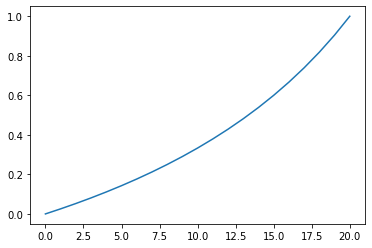

In [277]:
res = []
for i in range(21):
    inter = i
    union = (20-i)*2 + i
    jacard = inter/union
    res.append([inter, union, jacard])
    
res = pd.DataFrame(res)
plt.plot(np.arange(21), res[2])

In [259]:
comp = []
j = 0
for i in range(100):
    ratio = np.array(test[i, :].todense()).reshape(-1)
    vals = np.where(ratio)[0]
    x = np.array(csr[i,:].todense())
    for j in vals:
        y = np.array(csr[j,:].todense())
        calc = ((x>0) & (y>0)).sum() / ((x>0) | (y>0)).sum()
        comp.append([i,j,test[i, j]==calc])
        

        

In [260]:
pd.DataFrame(comp)[2].value_counts()

True    33830
Name: 2, dtype: int64

In [199]:
dists.shape

(10296950,)

In [200]:
unions.shape

(10296950,)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([    0,   161,   259,   388,   397,   470,   656,   686,  1070,
         1110,  1121,  1122,  1157,  1185,  1319,  1365,  1399,  1422,
 

In [222]:
i = 0
j = 259
print(z[i,j])

x = np.array(csr[i,:].todense())
y = np.array(csr[j,:].todense())

print(((x>0) & (y>0)).sum() / ((x>0) | (y>0)).sum())

0.14285714285714285
0.14285714285714285


In [221]:
i = 0
j= 259


0.14285714285714285

In [176]:
mask.shape

(10296950,)

In [169]:
intrsct.getnnz(axis=1)

array([253, 105, 330, ..., 276, 373, 362], dtype=int32)

In [173]:
dists

array([0.97435897, 0.97435897, 0.97435897, ..., 0.97435897, 0.91891892,
       0.97435897])

In [175]:
mask

array([False, False, False, ..., False, False, False])

In [ ]:
def pairwise_jaccard_sparse(csr, epsilon):
    """Computes the Jaccard distance between the rows of `csr`,
    smaller than the cut-off distance `epsilon`.
    """
    assert(0 < epsilon < 1)
    csr = csr_matrix(csr).astype(bool).astype(int)

    csr_rownnz = csr.getnnz(axis=1)
    intrsct = csr.dot(csr.T)

    nnz_i = np.repeat(csr_rownnz, intrsct.getnnz(axis=1))
    unions = nnz_i + csr_rownnz[intrsct.indices] - intrsct.data
    dists = 1.0 - intrsct.data / unions

    mask = (dists > 0) & (dists <= epsilon)
    data = dists[mask]
    indices = intrsct.indices[mask]

    rownnz = np.add.reduceat(mask, intrsct.indptr[:-1])
    indptr = np.r_[0, np.cumsum(rownnz)]

    out = csr_matrix((data, indices, indptr), intrsct.shape)
    return out

In [155]:
z

<30672x30672 sparse matrix of type '<class 'numpy.int64'>'
	with 613440 stored elements in Compressed Sparse Row format>

In [153]:
intersect = z.dot(z.transpose()) 

matrix([[20,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 20,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 20,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 20,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 20,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 20,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 20,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 20,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 20]])

In [120]:
d_rna_rnapredict

array([0.34843926, 0.41694461, 0.22513443, ..., 0.15275368, 0.25079609,
       0.26591212])

In [123]:
z = adata_adt.obsp['distances']

In [128]:
z.indptr()

(613440,)

In [131]:
sc.pp.neighbors(adata_adt, n_neighbors=2, n_pcs=18, use_rep='X_apca', metric='euclidean', knn=True)

In [132]:
adata_adt.obsp['distances']

<30672x30672 sparse matrix of type '<class 'numpy.float64'>'
	with 30672 stored elements in Compressed Sparse Row format>

In [91]:
adt_X_norm.shape

(30672, 25)

In [54]:
x[x!=0]

array([1.50516963, 1.59034216, 1.63127029, 1.46064603, 1.688344  ,
       1.71456659, 1.74695659, 1.58256221, 1.76533437, 1.69345582,
       1.74347591, 1.61666071, 1.77678072, 1.72778273, 1.39434147,
       1.66292846, 1.71682227, 1.68827868, 1.76053679])

In [55]:
y[y!=0]

array([1.82163155, 1.50516963, 1.81673348, 1.59034216, 1.63127029,
       1.46064603, 1.87325597, 2.15584397, 2.23173809, 2.34097099,
       2.02608824, 1.85228515, 1.92145824, 2.10237622, 1.79854715,
       1.688344  , 2.00593162, 1.89052117, 1.71456659, 1.74695659,
       2.11881256, 1.58256221, 1.81238329, 2.28322339, 1.92729592,
       1.78754866, 2.14795542, 1.76533437, 2.28438854, 1.84062052,
       1.69345582, 1.83877647, 2.02883196, 2.89416623, 1.94221258,
       2.30047774, 1.74347591, 1.61666071, 1.77678072, 2.05781221,
       3.43877578, 1.72778273, 2.03873825, 1.39434147, 2.05593252,
       1.66292846, 1.71682227, 2.03398323, 2.15619183, 1.68827868,
       1.81512761, 1.76053679])

In [74]:
x[x!=0].shape

(20,)

In [57]:
y[y!=0].shape

(52,)

In [65]:
(adata_adt.obsp['distances']>0).sum(axis=1)

matrix([[19],
        [19],
        [19],
        ...,
        [19],
        [19],
        [19]])

In [69]:
(adata_adt.obsp['distances']>0).sum(axis=0)

matrix([[52,  2,  1, ..., 75, 16,  1]])

In [70]:
(adata_adt.obsp['connectivities']>0).sum(axis=1)

matrix([[52],
        [20],
        [19],
        ...,
        [76],
        [29],
        [19]])